HSE, Applied Time Series Forecasitng , Winter 2022-23

<font color="green"> Lesson 8: Time Series Forecasting with ML </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:**
    - demand forecasting, lagged features, time series CV

**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

# Demand Time Series

In [54]:
import numpy as np
import pandas as pd
from copy import deepcopy

# don't forget to upload utils file to the colab session
from utils import qualityWAPE, qualityRMSE
import warnings, pylab

warnings.filterwarnings('ignore')

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"

In [3]:
# загружаем данные
ts_retail = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/retail_2products.csv', sep=';')
ts_retail['Date'] = pd.to_datetime(ts_retail['Date'], dayfirst = True)
ts_retail.set_index(['Date'], inplace=True)
ts_retail = ts_retail[:'2016-05-23']
ts_retail.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price
Date,,,,,,
2015-01-01,1,1,NaN,22.0,163.78,NaN
2015-01-02,1,1,NaN,41.0,163.78,NaN
2015-01-03,1,1,NaN,35.0,163.78,NaN
2015-01-04,1,1,NaN,72.0,163.78,NaN
2015-01-05,1,1,NaN,25.0,163.78,NaN


In [8]:
pivot_ts.columns[:1]

Int64Index([1], dtype='int64', name='SKU_id')

In [31]:
group_columns = ['Store_id','SKU_id']
', '.join([group_columns[i]+'={0['+str(i)+']}' for i in range(len(group_columns))])

'Store_id={0[0]}, SKU_id={0[1]}'

In [42]:
# Draw some time series
def plot_some_ts(ts_df, groupby_columns, time_column, target_column, ts_num = 10, aggregation_method = 'sum'):
  '''pivot original ts by group_columns'''
  pivot_ts = ts_df.groupby(groupby_columns + [time_column]).agg(aggregation_method)

  # concat multiple index to single column
  index_column_name = ', '.join([group_columns[i]+'={0['+str(i)+']}' for i in range(len(group_columns))])
  pivot_ts.index = [pivot_ts.index.map(index_column_name.format) , pivot_ts.index.get_level_values(len(group_columns))]

  # unstack by-column (column that contains ts name)
  pivot_ts = pivot_ts.unstack([0])[target_column]

  # plot first ts_num ts
  fig = pivot_ts[pivot_ts.columns[:ts_num]].plot().update_layout(height=350, width=1300,
                                                  title="first {0} ts for {1} variable".format(ts_num, target_column ),
    xaxis_title=time_column,
    yaxis_title=target_column+ ' value',
    legend_title='ts id columns: '+', '.join(group_columns)).show()
  return fig

plot_some_ts(ts_retail.reset_index(), ['Store_id','SKU_id'], 'Date', 'Demand', ts_num = 3)

In [43]:
# Fill missings  (note: step is domain specific)
ts_retail['Promo'] = ts_retail['Promo'].fillna(0)
ts_retail.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
ts_retail['Regular_Price'] = ts_retail['Regular_Price'].ffill().bfill()
ts_retail.reset_index().set_index(['Date'], inplace=True)

plot_some_ts(ts_retail.reset_index(), ['Store_id','SKU_id'], 'Date', 'Regular_Price', ts_num = 8)

# Add actual price (promo price when promo occurred or regular price otherwise)
ts_retail['Actual_Price'] = ts_retail.Promo_Price.combine_first(ts_retail.Regular_Price)
plot_some_ts(ts_retail.reset_index(), ['Store_id','SKU_id'], 'Date', 'Actual_Price', ts_num = 8)

In [44]:
# prepare test/train datasets
test_start_dt = '05-01-2016'
train = ts_retail.copy(deep=True)
train.loc[test_start_dt:, 'Demand'] = np.NaN
train.loc['01-01-2016':].plot()
test_y = ts_retail.loc[test_start_dt:, ['Store_id', 'SKU_id', 'Demand']]

plot_some_ts(test_y.reset_index(), ['Store_id','SKU_id'], 'Date', 'Demand', ts_num = 8)

In [45]:
test_y.shape

(4738, 3)

In [48]:
# Aggregate on Sku - All Stores level
sales_by_sku = train.groupby(['SKU_id','Date']).agg({'Demand':'sum','Promo':'sum','Store_id':'count','Actual_Price':'mean'}).reset_index().set_index('Date').rename(columns = {'Store_id':'Store_count'})
sales_by_sku.loc[test_start_dt:,'Demand'] = np.NaN # fill test period Demand with Nan

sales_by_sku[sales_by_sku['SKU_id'] == 1].plot()

# sales_by_sku[sales_by_sku['SKU_id'] == 2][['Demand', 'Actual_Price']].plot()

# sales_by_sku[sales_by_sku['SKU_id'] == 2][['Demand', 'Store_count']].plot()

In [51]:
np.array(range(10))+1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [58]:
rt_df = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/retail_2products.csv', sep = ';',parse_dates=['Date']).set_index('Date')

fig = go.Figure()
fig.add_trace(go.Scatter(x=rt_df[(rt_df['Store_id']==1) & (rt_df['SKU_id']==1)].tail(186).index,
                        y=rt_df[(rt_df['Store_id']==1) & (rt_df['SKU_id']==1)]['Demand'].tail(186)
                        , name="Demand"))

fig.add_trace(go.Scatter(x=rt_df[(rt_df['Store_id']==1) & (rt_df['SKU_id']==1)].tail(186).index,
                        y=rt_df[(rt_df['Store_id']==1) & (rt_df['SKU_id']==1)]['Regular_Price'].tail(186)
                        , name="Regular_Price", yaxis="y2"))

fig.add_trace(go.Scatter(x=rt_df[(rt_df['Store_id']==1) & (rt_df['SKU_id']==1)].tail(186).index,
                        y=rt_df[(rt_df['Store_id']==1) & (rt_df['SKU_id']==1)]['Promo_Price'].tail(186)
                        , name="Promo_Price", yaxis="y2"))

fig.add_trace(
    go.Scatter(x=rt_df[(rt_df['Store_id']==1) & (rt_df['SKU_id']==1)].tail(186).index,
                        y=rt_df[(rt_df['Store_id']==1) & (rt_df['SKU_id']==1)]['Promo'].tail(186)
                        , name="Promo", yaxis="y3"))

fig.update_layout(
    xaxis=dict(domain=[0.1, 0.95]),
    yaxis=dict(
        title="Demand",
    ),
    yaxis2=dict(
        title="Price",
        overlaying="y",
        side="right",
    ),
    yaxis3=dict(title="Promo", anchor="free", overlaying="y", autoshift=True),
)

fig.update_layout(height=500, width=1300).show()

In [65]:

def make_cross_series_plot(ts, columns_name, yaxis = [] ):
  fig = go.Figure()

  if len(yaxis) != len(columns_name):
    yaxis = list(np.array(range(len(columns_name)))+1)

  for c in range(len(columns_name)):
    # fig.add_trace(go.Scatter(x=ts.index,
    #                         y=ts[columns_name[c]]
    #                         , name=columns_name[c]
    #                         yaxis = 'y'+str(yaxis[c]+1)
    #                         ))
    print(columns_name[c])
    fig.add_trace(go.Scatter(x=ts.index,
                        y=ts[columns_name[c]]
                        , name=columns_name[c],
                             yaxis='y'+str(yaxis[c]+1)
                             ))

  fig.update_layout(height=500, width=1300).show()
  return

make_cross_series_plot(ts=sales_by_sku[sales_by_sku['SKU_id'] == 1], columns_name=['Demand', 'Promo', 'Actual_Price', 'Store_count'])

# fig.add_trace(go.Scatter(x=rt_df[(rt_df['Store_id']==1) & (rt_df['SKU_id']==1)].tail(186).index,
#                         y=rt_df[(rt_df['Store_id']==1) & (rt_df['SKU_id']==1)]['Regular_Price'].tail(186)
#                         , name="Regular_Price", yaxis="y2"))

# fig.add_trace(go.Scatter(x=rt_df[(rt_df['Store_id']==1) & (rt_df['SKU_id']==1)].tail(186).index,
#                         y=rt_df[(rt_df['Store_id']==1) & (rt_df['SKU_id']==1)]['Promo_Price'].tail(186)
#                         , name="Promo_Price", yaxis="y2"))

# fig.add_trace(
#     go.Scatter(x=rt_df[(rt_df['Store_id']==1) & (rt_df['SKU_id']==1)].tail(186).index,
#                         y=rt_df[(rt_df['Store_id']==1) & (rt_df['SKU_id']==1)]['Promo'].tail(186)
#                         , name="Promo", yaxis="y3"))

# fig.update_layout(
#     xaxis=dict(domain=[0.1, 0.95]),
#     yaxis=dict(
#         title="Demand",
#     ),
#     yaxis2=dict(
#         title="Price",
#         overlaying="y",
#         side="right",
#     ),
#     yaxis3=dict(title="yaxis3 title", anchor="free", overlaying="y", autoshift=True),
#     yaxis4=dict(
#         title="Promo",
#         anchor="free",
#         overlaying="y",
#         autoshift=True,
#     ),
# )

Demand
Promo
Actual_Price
Store_count


# ML for time series Forecasting

**Questions**
* Can classic ML algorithms (including DT regressor, Boosting, RF regressors)   be applied to the ts forecasting problem?
  - Yes, assuming that ts model is defined properly

* How CV should be organized for ts problem?

<img src = 'https://miro.medium.com/max/753/1*qvdnPF8ETV9mFdMT0Y_BBA.png' width = '2500px'>

## Feature generation for ML algorithms
**Questions**
* What features should be added to the original data set?
   - Calendar-dummy variables: holidays, day of week, day of month
   - Lagged-features
   - x-sindicated features (e.g price x store_number**2)

In [ ]:
# feature generation
data = sales_by_sku.reset_index().copy(deep = True)

data["weekday"] = data.Date.dt.weekday
data["monthday"] = data.Date.dt.day
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

,Date,SKU_id,Demand,Promo,Store_count,Actual_Price,weekday,monthday,is_weekend
0,2015-01-01,1,1180.0,0.0,73,163.920685,3,1,0
1,2015-01-02,1,3667.0,0.0,73,163.920685,4,2,0
2,2015-01-03,1,4987.0,0.0,73,163.920685,5,3,1
3,2015-01-04,1,5226.0,0.0,73,163.920685,6,4,1
4,2015-01-05,1,5951.0,0.0,73,163.920685,0,5,0


### Lagged Features Generation

**Questions**
* Classic TS models leverage ts structure information (level, seasonaliry, trend, etc) for forecasting. How to provide such information for classsic ML models?

  - Answer: use ES forecast as features for ML  -->
     - Use more complicated ts based feature generation https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/
<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/LaggedFeaturesGeneration.PNG?raw=true'>

In [ ]:
from itertools import product
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_

# train[['SKU_id', 'Store_id', 'Demand']].groupby(['SKU_id', 'Store_id']).agg({'mean', 'std', percentile(50)})

# добавляем лаги
def lagged_features(df
                    , target_var = 'demand'
                    , org_id_columns = ['product_rk', 'store_location_rk']
                    , all_id_columns =['product_rk', 'store_location_rk', 'period_start_dt']
                    , lags = [7, 14, 21, 28]
                    , windows = [7, 14]
                    , aggregation_methods = {'mean', 'median', percentile(10),  percentile(90)}
                    , filters = None
                    ):
    '''Calculate lagged features '''
    ''' df - data frame
        target_var - column name which is used to calculate lagged features
        org_id_columns - id columns, lagged featires is calculated within each id element independatnly
        all_id_columns - id columns + timestamp column
        lags -
        windows - list of windows, calculation is performed within time range length of window
        aggregation_methods - method of aggregation, e.g. 'mean', 'median', 'std', etc.
        filter = dict of dict: {<column_name>:{'postfix':'condition of the filter'}}
    '''
    out_df = deepcopy(df)

    if filters is None:
      filters = {'':{''}}

    keys, values = zip(*filters.items())
    for bundle in product(*values):
      # print(bundle)
        # define dates for each SKU and Store pairs
      condition = ' & '.join([keys[i]+ filters[keys[i]][bundle[i]] for i in range(len(keys))])
      name =  '_'.join([bundle[i] for i in range(len(keys))])
      if len(condition) >0:
        _idx = df.eval(condition)
      else:
        _idx = df.index>=0

      if len(df[_idx].index)>0:
        for w in windows:
          lf_df = df[_idx].set_index(all_id_columns)[target_var].\
                    groupby(level=org_id_columns).apply(lambda x: x.rolling(window=w, min_periods = 1).agg(aggregation_methods))
          for l in lags:
            new_names = {x: "lag{0}_wdw{1}_{2}_{3}".
                          format(l, w, x, name) for x in lf_df.columns }

            out_df = pd.merge(out_df, lf_df.shift(l).reset_index().rename(columns = new_names),
                  how='left', on =all_id_columns )


    return out_df

In [ ]:
from ipywidgets import IntProgress

from itertools import product
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_

# add missing dates to GroupBy.Core object
def fill_missing_dates(x, date_col):
    min_date, max_date = x[date_col].min(), x[date_col].max()
    groupby_day = x.groupby(pd.PeriodIndex(x[date_col], freq='D'))
    results = groupby_day.sum(min_count=1)

    idx = pd.period_range(min_date, max_date)
    results = results.reindex(idx, fill_value=np.nan)

    results.index.rename(date_col, inplace=True)

    return results


def calc_preag_fill(data, group_col, date_col, target_cols, preagg_method):
    ## calc preaggregation
    data_preag = data.groupby(group_col).agg(
        preagg_method)[target_cols].reset_index()

    ## fill missing dates
    data_preag_filled = data_preag.groupby(group_col[:-1]).apply(
        fill_missing_dates, date_col=date_col).drop(group_col[:-1],
                                                    axis=1).reset_index()

    ## return DataFrame with calculated preaggregation and filled missing dates
    return data_preag_filled


def calc_rolling(data_preag_filled, group_col, date_col, method, w):

    ## calc rolling stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).rolling(window=w, min_periods=1).agg(method)).drop(group_col[:-1], axis=1)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def calc_ewm(data_preag_filled, group_col, date_col, span):
    ## calc ewm stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).ewm(span=span).mean()).drop(group_col[:-1], axis=1)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def shift(lf_df_filled, group_col, date_col, lag):

    lf_df = lf_df_filled.groupby(
        level=group_col[:-1]).apply(lambda x: x.shift(lag)).reset_index()
    lf_df[date_col] = pd.to_datetime(lf_df[date_col].astype(str))

    ## return DataFrame with following columns: filter_col, id_cols, date_col and shifted stats
    return lf_df


def generate_lagged_features(
        data: pd.DataFrame,
        target_cols: list = ['Demand'],
        id_cols: list = ['SKU_id', 'Store_id'],
        date_col: str = 'Date',
        lags: list = [7, 14, 21, 28],
        windows: list = ['7D', '14D', '28D', '56D'],
        preagg_methods: list = ['mean'],
        agg_methods: list = ['mean', 'median', percentile(10), pd.Series.skew],
        dynamic_filters: list = ['weekday', 'Promo'],
        ewm_params: dict = {'weekday': [14, 28], 'Promo': [14, 42]}) -> pd.DataFrame:

    '''
    data - dataframe with default index
    target_cols - column names for lags calculation
    id_cols - key columns to identify unique values
    date_col - column with datetime format values
    lags - lag values(days)
    windows - windows(days/weeks/months/etc.),
        calculation is performed within time range length of window
    preagg_methods - applied methods before rolling to make
        every value unique for given id_cols
    agg_methods - method of aggregation('mean', 'median', percentile, etc.)
    dynamic_filters - column names to use as filter
    ewm_params - span values(days) for each dynamic_filter
    '''

    data = data.sort_values(date_col)
    out_df = deepcopy(data)
    dates = [min(data[date_col]), max(data[date_col])]

    total = len(target_cols) * len(lags) * len(windows) * len(preagg_methods) * len(agg_methods) * len(dynamic_filters)
    progress = IntProgress(min=0, max=total)
    display(progress)

    for filter_col in dynamic_filters:
        group_col = [filter_col] + id_cols + [date_col]
        for lag in lags:
            for preagg in preagg_methods:
                data_preag_filled = calc_preag_fill(data, group_col, date_col,
                                                    target_cols, preagg)

                ## add ewm features
                for alpha in ewm_params.get(filter_col, []):
                    ewm_filled = calc_ewm(data_preag_filled, group_col,
                                          date_col, alpha)
                    ewm = shift(ewm_filled, group_col, date_col, lag)
                    new_names = {x: "{0}_lag{1}d_alpha{2}_key{3}_preag{4}_{5}_dynamic_ewm".\
                        format(x, lag, alpha, '_'.join(id_cols), preagg, filter_col) for x in target_cols}

                    out_df = pd.merge(out_df,
                                      ewm.rename(columns=new_names),
                                      how='left',
                                      on=group_col)

                ## add rolling features
                for w in windows:
                    for method in agg_methods:
                        rolling_filled = calc_rolling(data_preag_filled,
                                                      group_col, date_col,
                                                      method, w)

                        ## lf_df - DataFrame with following columns: filter_col, id_cols, date_col, shifted rolling stats
                        rolling = shift(rolling_filled, group_col, date_col,
                                        lag)

                        method_name = method.__name__ if type(
                            method) != str else method

                        new_names = {x: "{0}_lag{1}d_w{2}_key{3}_preag{4}_ag{5}_{6}_dynamic_rolling".\
                                     format(x, lag, w, '_'.join(id_cols), preagg, method_name, filter_col) for x in target_cols}

                        out_df = pd.merge(out_df,
                                          rolling.rename(columns=new_names),
                                          how='left',
                                          on=group_col)
                        progress.value += 1

    return out_df

**Questions**
  * How to define lagges based on forecast horizon?
    - Lag must be less or equal than forecast horizon in order to prevent target leakage!
    - We are building forecast fot the next 22 days => minimal lag value is 22

In [ ]:
target_cols = ['Demand']
id_cols = ['SKU_id']
date_col = 'Date'
built_in_funcs = [pd.Series.kurtosis, pd.Series.skew]

# flts = {'Promo': {'oprm':'>0', 'npromo':'==0', 'aprm':'>-1'}, 'weekday' : {'md':'==0', 'tue':'==1', 'wd':'==2', 'th':'==3', 'fr':'==4', 'sa':'==5', 'su':'==6', 'anyday':'>-1'}}


data['NoFilter'] = 1
data_lagged_features = generate_lagged_features(data
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [22, 28, 35]
                    , windows = ['14D', '21D', '28D', '56D']
                    , preagg_methods = ['sum'] # ['mean', 'count']
                    , agg_methods = ['mean', percentile(10),  percentile(90)]
                    , dynamic_filters = ['Promo', 'NoFilter']
                    , ewm_params={'NoFilter': [14, 28], 'Promo': [14, 28]}
                    )

IntProgress(value=0, max=72)

In [ ]:
# number of columns
print(len(data_lagged_features.columns))
data_lagged_features.columns

94


Index(['Date', 'SKU_id', 'Demand', 'Promo', 'Store_count', 'Actual_Price',
       'weekday', 'monthday', 'is_weekend', 'NoFilter',
       'Demand_lag22d_alpha14_keySKU_id_preagsum_Promo_dynamic_ewm',
       'Demand_lag22d_alpha28_keySKU_id_preagsum_Promo_dynamic_ewm',
       'Demand_lag22d_w14D_keySKU_id_preagsum_agmean_Promo_dynamic_rolling',
       'Demand_lag22d_w14D_keySKU_id_preagsum_agpctl10_Promo_dynamic_rolling',
       'Demand_lag22d_w14D_keySKU_id_preagsum_agpctl90_Promo_dynamic_rolling',
       'Demand_lag22d_w21D_keySKU_id_preagsum_agmean_Promo_dynamic_rolling',
       'Demand_lag22d_w21D_keySKU_id_preagsum_agpctl10_Promo_dynamic_rolling',
       'Demand_lag22d_w21D_keySKU_id_preagsum_agpctl90_Promo_dynamic_rolling',
       'Demand_lag22d_w28D_keySKU_id_preagsum_agmean_Promo_dynamic_rolling',
       'Demand_lag22d_w28D_keySKU_id_preagsum_agpctl10_Promo_dynamic_rolling',
       'Demand_lag22d_w28D_keySKU_id_preagsum_agpctl90_Promo_dynamic_rolling',
       'Demand_lag22d_w56D

## ML model definition
**Questions**
* Shall we train only one model for all data?

<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/Informativity.png?raw=true'>

 See details here
http://www.machinelearning.ru/wiki/images/3/3e/Voron-ML-Logic.pdf

* Can we define ML pipeline based on business logics?

In [ ]:
# put date in index
data_lagged_features.set_index('Date', inplace = True)
data_lagged_features.loc[test_start_dt:].head()

,SKU_id,Demand,Promo,Store_count,Actual_Price,weekday,monthday,is_weekend,NoFilter,Demand_lag22d_alpha14_keySKU_id_preagsum_Promo_dynamic_ewm,...,Demand_lag35d_w14D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling,Demand_lag35d_w21D_keySKU_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag35d_w21D_keySKU_id_preagsum_agpctl10_NoFilter_dynamic_rolling,Demand_lag35d_w21D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling,Demand_lag35d_w28D_keySKU_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag35d_w28D_keySKU_id_preagsum_agpctl10_NoFilter_dynamic_rolling,Demand_lag35d_w28D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling,Demand_lag35d_w56D_keySKU_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag35d_w56D_keySKU_id_preagsum_agpctl10_NoFilter_dynamic_rolling,Demand_lag35d_w56D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-01,2,NaN,0.0,103,138.50,6,1,1,1,342.720725,...,5673.6,2152.904762,316.0,5619.0,1697.964286,306.7,5565.1,2495.071429,315.5,9691.5
2016-05-01,1,NaN,0.0,103,131.16,6,1,1,1,15025.884077,...,66737.0,39502.857143,15790.0,65777.0,34242.642857,15478.6,65611.1,33248.732143,15733.5,63728.5
2016-05-02,1,NaN,0.0,103,131.16,0,2,0,1,14857.320753,...,66737.0,39210.142857,15298.0,65777.0,34177.642857,15478.6,65611.1,33001.553571,15616.5,63728.5
2016-05-02,2,NaN,0.0,103,138.50,0,2,0,1,353.690913,...,5673.6,2157.952381,317.0,5619.0,1698.071429,306.7,5565.1,2489.125000,315.5,9691.5
2016-05-03,2,NaN,103.0,103,106.01,1,3,0,1,NaN,...,5595.9,2157.952381,317.0,5619.0,1699.857143,306.7,5565.1,2485.017857,315.5,9691.5


In [ ]:
# train specific model for each SKU
sku1_train = data_lagged_features[data_lagged_features['SKU_id'] == 1]
sku2_train = data_lagged_features[data_lagged_features['SKU_id'] == 2]

## ML Model Training

In [ ]:
# try lightgbm as ml algorithm
import lightgbm as lgb
kwargs={'early_stopping_rounds':10,'verbose':2}

def plot_feature_importance(model, X , num = 20):
  # , fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    # plt.figure(figsize=fig_size)
    # sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    # plt.savefig('lgbm_importances-01.png')
    plt.show()

In [ ]:
# without CV
lgbm1 = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')
lgbm1.fit(X = sku1_train.loc[:test_start_dt].drop(['SKU_id','Demand'], axis=1), y = sku1_train.loc[:test_start_dt].Demand)

lgbm2 = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')

lgbm2.fit(X = sku2_train.loc[:test_start_dt].drop(['SKU_id','Demand'], axis=1), y = sku2_train.loc[:test_start_dt].Demand)

LGBMRegressor(feature_fraction=0.7, metric='mae', n_estimators=500,
              num_leaves=40, subsample=0.4)

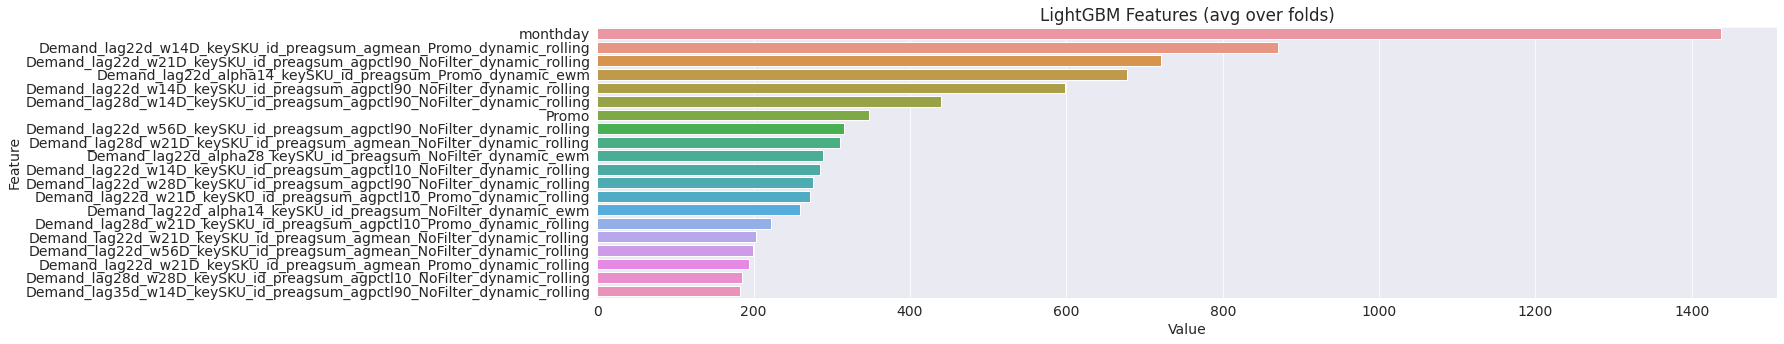

In [ ]:
plot_feature_importance(lgbm1, sku1_train[sku1_train.columns[2:]], num = 20)

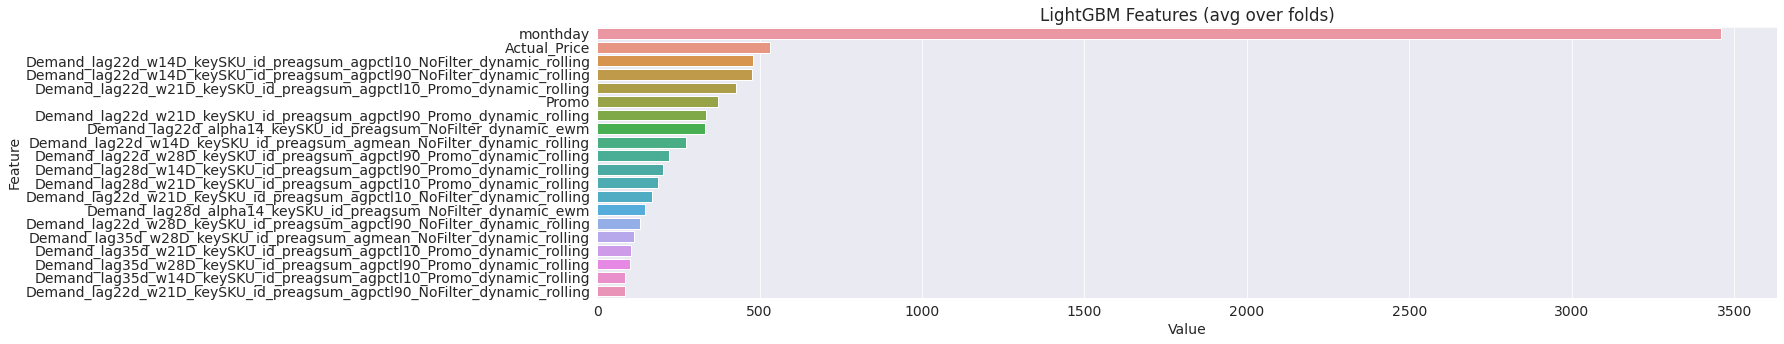

In [ ]:
plot_feature_importance(lgbm2, sku2_train[sku2_train.columns[2:]], num = 20)

### Cross-validation for time series
 **Caution**: ml parameters tuning steps are omitted! Only tech approach is shown.

In [ ]:
#  time series cross validation
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics, kwargs={}):
    print('Size train set: {}'.format(X_train.shape))

    # size of a fold
    fold_size = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(fold_size))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds
    for i in range(2, number_folds + 1):
        print('')
        train_share = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(fold_size*i)]
        y = y_train[:(fold_size*i)]
        print('Size of train and test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * train_share))

        # folds used to train the model
        X_trainFolds = X[:index]
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds, **kwargs, eval_set=[(X_testFold, y_testFold)])
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds
    return errors.mean()

In [ ]:
# Train sets
X_train1 = sku1_train.loc[:test_start_dt].drop(['SKU_id','Demand'], axis=1)
y_train1 = sku1_train.loc[:test_start_dt].Demand
X_train2 = sku2_train.loc[:test_start_dt].drop(['SKU_id', 'Demand'], axis=1)
y_train2 = sku2_train.loc[:test_start_dt].Demand

In [ ]:
# test sets
X_test1 = sku1_train.loc[test_start_dt:].drop(['SKU_id','Demand'], axis=1)
X_test2 = sku2_train.loc[test_start_dt:].drop(['SKU_id','Demand'], axis=1)

In [ ]:
# WAPE realizaion for lgbm train
def wape(y_pred, y_true):
    res = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
    return res

In [ ]:
# run TS CV for the sku 1 (if needed)
%%time
performTimeSeriesCV(X_train1, y_train1, 17, lgbm1, wape, kwargs)

In [ ]:
# run TS CV for the sku 2 (if needed)
%%time
performTimeSeriesCV(X_train2, y_train2, 17, lgbm2, wape, kwargs)

Size train set: (487, 91)
Size of each fold: 28

Splitting the first 2 chunks at 1/2
Size of train and test: (56, 91)
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 222.772
[4]	valid_0's l1: 222.772
[6]	valid_0's l1: 222.772
[8]	valid_0's l1: 222.772
[10]	valid_0's l1: 222.772
Early stopping, best iteration is:
[1]	valid_0's l1: 222.772

Splitting the first 3 chunks at 2/3
Size of train and test: (84, 91)
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 93.2262
[4]	valid_0's l1: 93.5063
[6]	valid_0's l1: 93.6953
[8]	valid_0's l1: 93.856
[10]	valid_0's l1: 92.7009
[12]	valid_0's l1: 92.806
[14]	valid_0's l1: 90.2234
[16]	valid_0's l1: 90.3503
[18]	valid_0's l1: 90.4345
[20]	valid_0's l1: 89.5896
[22]	valid_0's l1: 88.3665
[24]	valid_0's l1: 87.2225
[26]	valid_0's l1: 86.7305
[28]	valid_0's l1: 85.713
[30]	valid_0's l1: 85.2533
[32]	valid_0's l1: 84.5477
[34]	valid_0's l1: 83.6033
[36]	valid_0's l1: 83.1731
[38]	valid_0's l1

38.85161553812844

## Forecast Generation with ML

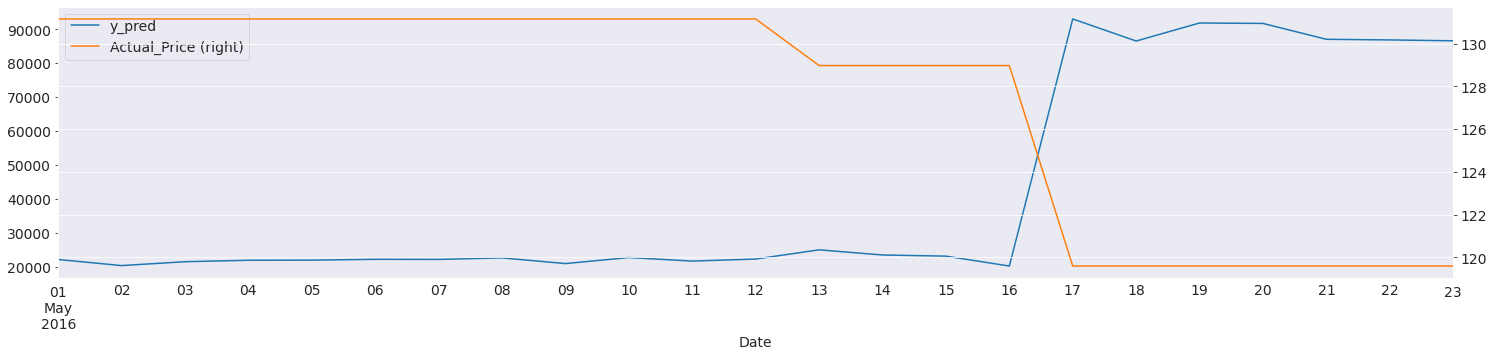

In [ ]:
# forecast for sku 1
X_test1['y_pred'] = lgbm1.predict(X_test1)
X_test1[['y_pred', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

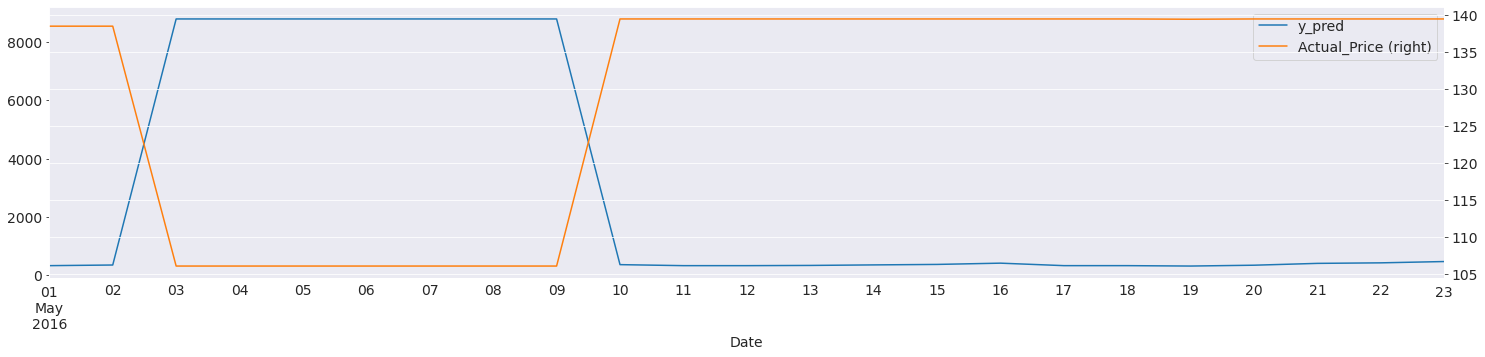

In [ ]:
# forecast for sku 2
X_test2['y_pred'] = lgbm2.predict(X_test2[X_test2.columns[:-1]])
X_test2[['y_pred', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

**Note**: forecast highly depends on key drivers

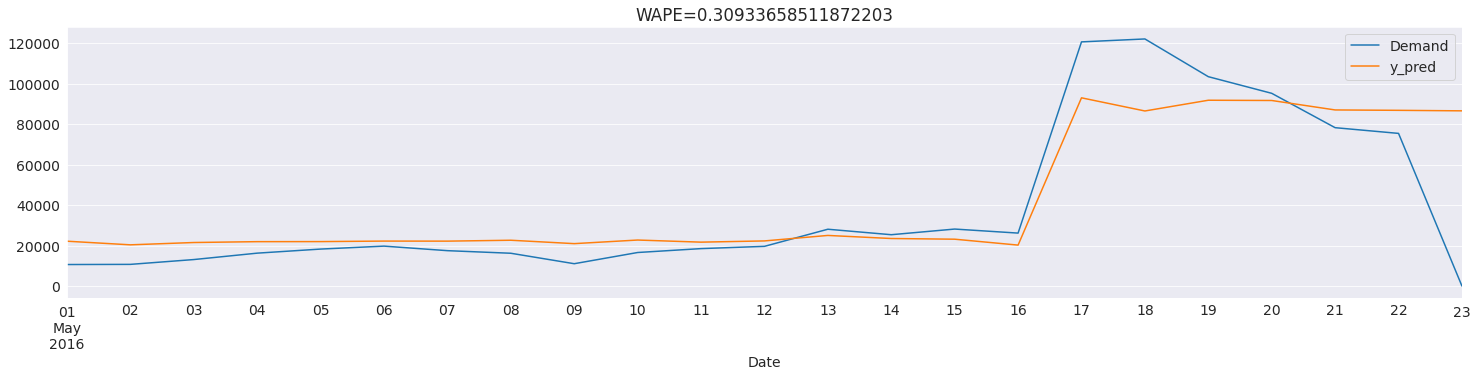

In [ ]:
y_true = test_y.groupby(['SKU_id','Date']).agg({'Demand':'sum'}).reset_index().set_index('Date')

# WAPE for sku 1
qlt , _ = qualityWAPE(y_true[y_true['SKU_id']==1]['Demand'], X_test1['y_pred'])

#draw forecast and actuals
X_test1.merge(y_true[y_true['SKU_id']==1], how = 'inner', left_index = True, right_index = True)[['Demand', 'y_pred']].plot(title = 'WAPE='+str(qlt))


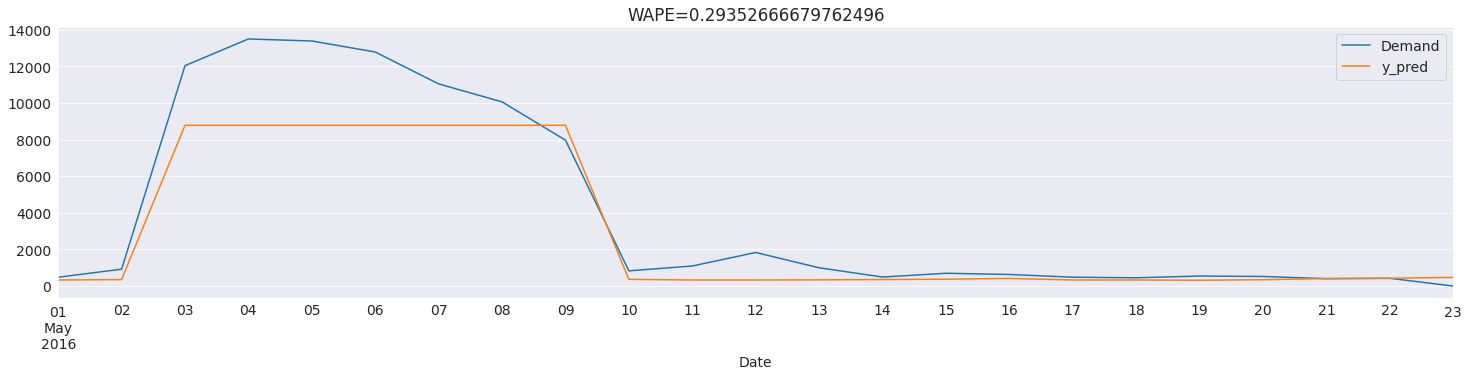

In [ ]:
# WAPE for sku 2
qlt , _ = qualityWAPE(y_true[y_true['SKU_id']==2]['Demand'], X_test2['y_pred'])

#draw forecast and actuals
X_test2.merge(y_true[y_true['SKU_id']==2], how = 'inner', left_index = True, right_index = True)[['Demand', 'y_pred']].plot(title = 'WAPE='+str(qlt))


**Materials**
* Cross-validation for time series https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
* M - competition
  - M5: https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/163414
  - M4: https://www.sciencedirect.com/science/article/pii/S0169207019301128